In [17]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Specifying the paths

In [18]:
csv_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results\csv\results.csv"
)
figures_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results/figures"
)
figures_path.mkdir(exist_ok=True, parents=True)

#### Loading in data

In [19]:
df = pd.read_csv(csv_path, parse_dates=["datetime"])
df["cl_cd"] = df["cl"] / df["cd"]
df["cl_cd_abs"] = (df["cl"] / df["cd"]).abs()
df["failed"] = (~df[["block_mesh", "check_mesh", "simple"]]).any(axis=1)
df_filtered = df.dropna(subset=["cl", "cd"]).copy()
df_filtered["moving_avg"] = df_filtered["cl_cd_abs"].rolling(window=30).mean()

#### Progress plot

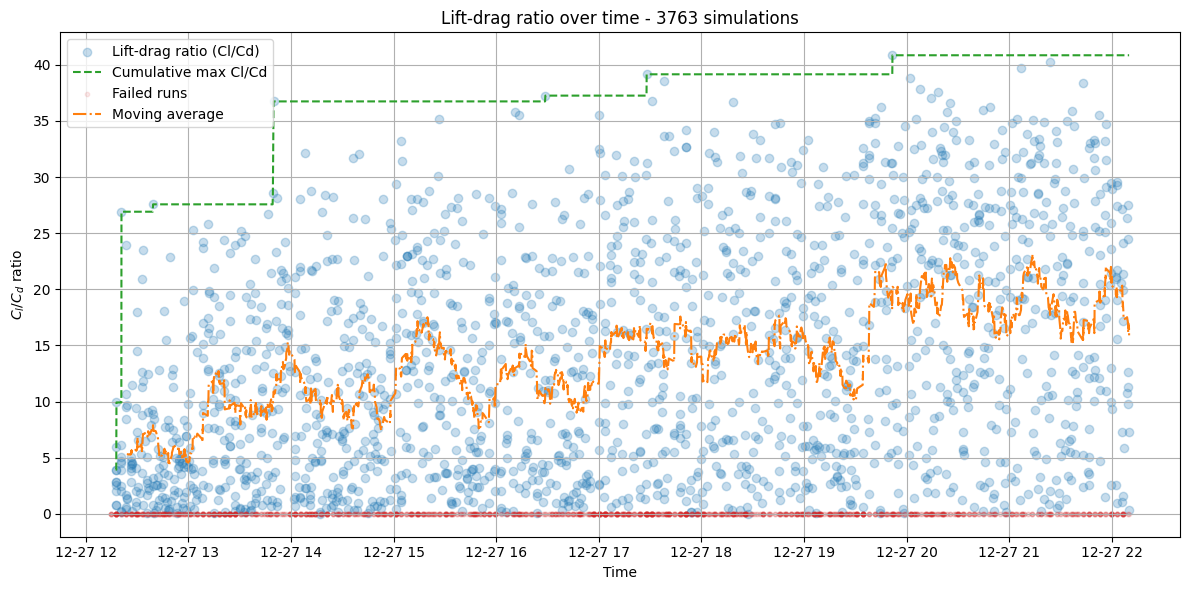

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"],
    label="Lift-drag ratio (Cl/Cd)",
    marker="o",
    color="tab:blue",
    alpha=0.25,
)
plt.plot(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"].cummax(),
    label="Cumulative max Cl/Cd",
    linestyle="--",
    color="tab:green",
)
plt.scatter(
    df[df["failed"]]["datetime"],
    -df[df["failed"]]["failed"],
    s=10,
    color="tab:red",
    alpha=0.1,
    label="Failed runs",
)

plt.plot(
    df_filtered["datetime"],
    df_filtered["moving_avg"],
    label="Moving average",
    linestyle="-.",
    color="tab:orange",
)

plt.title(f"Lift-drag ratio over time - {len(df)} simulations")
plt.xlabel("Time")
plt.ylabel("$C_l/C_d$ ratio")

# Use a locator to reduce the density of x-ticks
# locator = mdates.HourLocator(interval=1)
# formatter = mdates.DateFormatter("%H:%M")
# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(
    "results/figures/27122024 - OpenFOAM - Lift-drag ratio over time.png", dpi=300
)
plt.show()

#### Attempts at model reduction

Mean Squared Error: 12.280772431747335
Mean Absolute Error: 2.719161847713029
Mean Percentage Error: 6.99%

Dummy Model Evaluation:
Mean Squared Error (Dummy): 177.0655821970221
Mean Absolute Error (Dummy): 10.420704397563481
Mean Percentage Error (Dummy): 20.22%


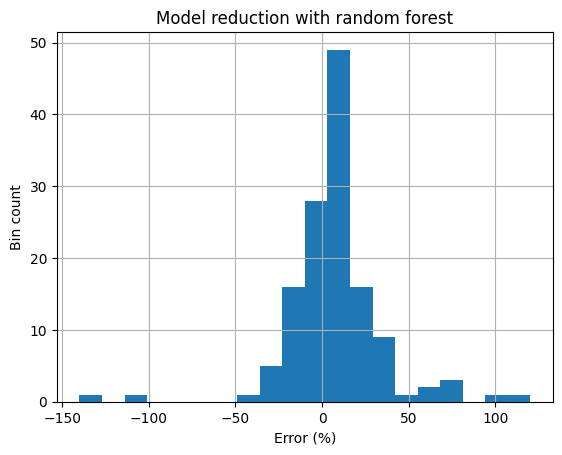

In [27]:
df_subset = df_filtered[
    (df_filtered["cl_cd_abs"] > 5.0) & (df_filtered["cl_cd_abs"] < 1005.0)
]

X = df_subset[["x0", "x1", "x2", "x3", "x4", "x5"]]
y = df_subset["cl_cd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
percentage_error = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Percentage Error: {percentage_error:.2f}%")

# Dummy method: Mean baseline
y_dummy_pred = [y_train.mean()] * len(y_test)
mse_dummy = mean_squared_error(y_test, y_dummy_pred)
mae_dummy = mean_absolute_error(y_test, y_dummy_pred)
percentage_error_dummy = np.mean((y_test - y_dummy_pred) / y_test) * 100

print("\nDummy Model Evaluation:")
print(f"Mean Squared Error (Dummy): {mse_dummy}")
print(f"Mean Absolute Error (Dummy): {mae_dummy}")
print(f"Mean Percentage Error (Dummy): {percentage_error_dummy:.2f}%")

plt.hist((y_test - y_pred) / y_test * 100, bins=20)
plt.xlabel("Error (%)")
plt.ylabel("Bin count")
plt.title("Model reduction with random forest")
plt.grid()

plt.savefig(
    "results/figures/27122024 - OpenFOAM - random forest model reduction.png", dpi=300
)

In [25]:
pd.set_option("display.max_rows", None)
reduced_form = pd.DataFrame({"pred": y_pred, "test": y_test.values}).sort_values(
    by="test", ascending=False
)
reduced_form["error"] = reduced_form["test"] - reduced_form["pred"]
reduced_form["percent_error"] = (reduced_form["test"] - reduced_form["pred"]) / reduced_form["test"]

reduced_form

,pred,test,error,percent_error
71,36.987335,39.696824,2.709489,0.068255
5,33.408625,37.251156,3.842530,0.103152
50,34.192593,35.176644,0.984051,0.027975
31,35.336901,34.035501,-1.301400,-0.038237
16,27.910722,32.340265,4.429543,0.136967
57,31.271167,31.930967,0.659800,0.020663
14,30.031353,31.727541,1.696189,0.053461
126,31.627993,31.660707,0.032713,0.001033
37,27.936056,31.248042,3.311986,0.105990
42,26.868081,31.225685,4.357604,0.139552
